In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import os
import librosa
from pyspark.sql import *
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from scipy.io import wavfile
import scipy.stats as stats

# Extract MFCCs for one sample:
First, we will start by checking out an audio data sample and extracting it's Mel-frequency cepstral coefficients (MFCCs).


In [2]:
current_path = os.getcwd()
file_path = os.path.join(current_path,"CETUC", "Full", "F000-0000.wav")
audio_data, sample_rate = librosa.load(file_path)

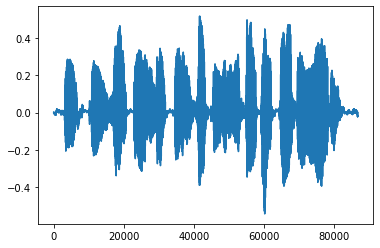

In [3]:
plt.figure()
plt.plot(audio_data)
plt.show()

In [4]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate)

#Get the mean
mfccs_mean = np.mean(mfccs.T, axis= 0)
len(mfccs_mean)

20

## Create dataframe from all samples using the MFCCs as features


In [7]:
def extract_MFCCs(files):
    data_list = []
    print("Extracting features...")
    for i, file in enumerate(files):
        file_path = os.path.join(current_path,"CETUC", "Full", file)
        audio_data, sample_rate = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate)
        mfccs_mean = list(np.mean(mfccs.T, axis= 0))
        if file[0] == 'F':
            gender = 0
        if file[0] == 'M': 
            gender = 1
        
        sample_features = [str(file), mfccs_mean, gender]
        data_list.append(sample_features)
        
        print(f"\r{i/len(files)*100:.3f}% complete",end='')
    # print(f"{i/len(files)*100} percent complete")
    print("\nMFCCs features extracted successfully")
    return data_list

In [8]:
current_path = os.getcwd()
file_path = os.path.join(current_path,"CETUC", "Full")
audio_files = os.listdir(file_path)
data_list = extract_MFCCs(audio_files)
df = pd.DataFrame(data_list, columns = ['FileName', 'MFCCs', 'Gender'])
df.to_csv('data/CETUC_MFCCs_data.csv', index=False)

Extracting features...
30.571% complete

KeyboardInterrupt: 

# Extract frequency features

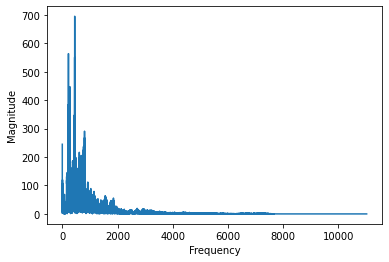

In [9]:
current_path = os.getcwd()
file_path = os.path.join(current_path,"CETUC", "Full", "F000-0000.wav")
audio_data, sample_rate = librosa.load(file_path)
step = int(sample_rate)
window_frequencies = []
top_freq = []

ft = np.fft.fft(audio_data)
magnitude = np.abs(ft)
frequency = np.linspace(0, sample_rate, len(magnitude))

plt.figure()
plt.plot(frequency[:int(len(frequency)/2)], magnitude[:int(len(frequency)/2)])
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()



In [13]:
def get_frequencies(files):
    frequencies_list = []
    gender_list = []
    FileName_list = []
    print("Extracting frequencies...")
    for k, file in enumerate(files):
        file_path = os.path.join(current_path,"CETUC", "Full", file)
        if file[0] == 'F':
            gender = 0
        if file[0] == 'M': 
            gender = 1
        audio_data, sample_rate = librosa.load(file_path, sr=16000)

        step = int(3200) #3200 sampling points every 1/5 sec
        window_frequencies = []

        for i in range(0,len(audio_data),step):
            ft = np.fft.fft(audio_data[i:i+step]) #fft returns the list N complex numbers
            freqs = librosa.fft_frequencies(sr=16000, n_fft=len(ft))
            freqs = np.fft.fftfreq(len(ft)) #fftq tells you the frequencies associated with the coefficients
            imax = np.argmax(np.abs(ft))
            freq = freqs[imax]
            freq_in_hz = abs(freq *sample_rate)
            window_frequencies.append(freq_in_hz)
            print(window_frequencies)
        FileName_list.append(file)
        gender_list.append(gender)
        frequencies_list.append(window_frequencies)
        print(f"\r{k/len(files)*100:.3f}% complete",end='')
    return frequencies_list, gender_list, FileName_list

In [14]:
def get_features(frequencies):

  nobs, minmax, mean, variance, skew, kurtosis =  stats.describe(frequencies)
  median   = np.median(frequencies)
  mode     = stats.mode(frequencies).mode[0]
  std      = np.std(frequencies)
  low,peak = minmax
  q75,q25  = np.percentile(frequencies, [75 ,25])
  iqr      = q75 - q25
  return nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr

In [ ]:
current_path = os.getcwd()
file_path = os.path.join(current_path,"CETUC", "Full")
audio_files = os.listdir(file_path)
frequencies, gender_list, FileName_list = get_frequencies(audio_files)
features_list = []
for i, frequency in enumerate(frequencies):
    nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr = get_features(frequency)
    features_list.append([FileName_list[i], nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr, gender_list[i]])
df = pd.DataFrame(features_list, columns = ['FileName', 'nobs', 'mean', 'skew', 'kurtosis', 'median', 'mode', 'std', 'low', 'peak', 'q25', 'q75', 'iqr', 'Gender'])
df.to_csv('data/CETUC_Features_data.csv', index=False)

# Extract F0 Features

In [ ]:
def get_f0(files):
    frequencies_list = []
    gender_list = []
    FileName_list = []
    print("Extracting frequencies...")
    for k, file in enumerate(files):
        file_path = os.path.join(current_path,"CETUC", "Full", file)
        if file[0] == 'F':
            gender = 0
        if file[0] == 'M': 
            gender = 1
        audio_data, sample_rate = librosa.load(file_path, sr=16000)

        step = int(3200) #3200 sampling points every 1/5 sec
        window_frequencies = []

        for i in range(0,len(audio_data),step):
            f0, voiced_flag, voiced_probs = librosa.pyin(audio_data[i:i+step], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
            f0 = [x for x in f0 if not np.isnan(x)]

            ft = np.fft.fft(audio_data[i:i+step]) #fft returns the list N complex numbers
            freqs = librosa.fft_frequencies(sr=16000, n_fft=len(ft))
            #freqs = np.fft.fftfreq(len(ft)) #fftq tells you the frequencies associated with the coefficients
            imax = np.argmax(np.abs(ft))
            freq = freqs[imax]
            freq_in_hz = abs(freq *sample_rate)
            window_frequencies.append(freq_in_hz)
        FileName_list.append(file)
        gender_list.append(gender)
        frequencies_list.append(window_frequencies)
        print(f"\r{k/len(files)*100:.3f}% complete",end='')
    return frequencies_list, gender_list, FileName_list